<a href="https://colab.research.google.com/github/ellierobin54/Utimaco-Project/blob/main/Utimaco_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installtion for the necessary library
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.5MB/s 
     |████████████████████████████████| 9.5MB 15.8MB/s 
     |████████████████████████████████| 2.1MB 44.1MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
import time
import datetime
import itertools
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse
import random  
from keras import backend
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import ARIMA, auto_arima

# Datasets

Dataset have three variables: Timestamp, CPU %, Memory %

The original data is from: https://github.com/alibaba/clusterdata/blob/master/cluster-trace-v2018/trace_2018.md

This data set is already cleaned from other repo due to the large size. (removed NA, replaced the Timestamp value from seconds to datetime) 

Here, we choose 6 computers' data with the largest size.

Things you should consider is that CPU is in % and the Timestamp is not consistence (meaning that the interval are not consistence).


In [3]:
dx=pd.read_csv("https://raw.githubusercontent.com/ellierobin54/Utimaco-Project/main/data1.csv")
dx2=pd.read_csv("https://raw.githubusercontent.com/ellierobin54/Utimaco-Project/main/data2.csv")
dx3=pd.read_csv("https://raw.githubusercontent.com/ellierobin54/Utimaco-Project/main/data3.csv")
dx4=pd.read_csv("https://raw.githubusercontent.com/ellierobin54/Utimaco-Project/main/data4.csv")
dx5=pd.read_csv("https://raw.githubusercontent.com/ellierobin54/Utimaco-Project/main/data5.csv")
dx6=pd.read_csv("https://raw.githubusercontent.com/ellierobin54/Utimaco-Project/main/data6.csv")
dx.head()

,Unnamed: 0,Timestamp,CPU %,Memory %
0,0,10,28.0,91
1,1,130,20.0,91
2,2,160,19.0,92
3,3,170,16.0,92
4,4,280,20.0,92


## Data Cleaning

In the case where data is in the second, please use the function **convert** to convert the seconds into the date and time value. If the data is already is written as date and time, please skip the process.

In [4]:
# In the case where data is in the seconds, 
# please use this function to convert the data into the date and time.

def convert(data): 
    x=[]
    for sec in data:
        ty_res = time.gmtime(sec)
        res = time.strftime("%m-%d %H:%M:%S",ty_res)
        x.append(res)
    return x

In [5]:
dx['Timestamp']= convert(dx['Timestamp'])
dx2['Timestamp']= convert(dx2['Timestamp'])
dx3['Timestamp']= convert(dx3['Timestamp'])
dx4['Timestamp']= convert(dx4['Timestamp'])
dx5['Timestamp']= convert(dx5['Timestamp'])
dx6['Timestamp']= convert(dx6['Timestamp'])

This part is where you convert the date and time into *Datetime*. This process is necessary in order to draw graph Time Series.

In [6]:
dx["Timestamp"] = pd.to_datetime(dx['Timestamp'], format="%m-%d %H:%M:%S")
dx2["Timestamp"] = pd.to_datetime(dx2['Timestamp'], format="%m-%d %H:%M:%S")
dx3["Timestamp"] = pd.to_datetime(dx3['Timestamp'], format="%m-%d %H:%M:%S")
dx4["Timestamp"] = pd.to_datetime(dx4['Timestamp'], format="%m-%d %H:%M:%S")
dx5["Timestamp"] = pd.to_datetime(dx5['Timestamp'], format="%m-%d %H:%M:%S")
dx6["Timestamp"] = pd.to_datetime(dx6['Timestamp'], format="%m-%d %H:%M:%S")

In [7]:
dx=dx.set_index(dx['Timestamp'])
dx2=dx2.set_index(dx2['Timestamp'])
dx3=dx3.set_index(dx3['Timestamp'])
dx4=dx4.set_index(dx4['Timestamp'])
dx5=dx5.set_index(dx5['Timestamp'])
dx6=dx6.set_index(dx6['Timestamp'])

In [8]:
# This will only keep the CPU %. 
# If you want to include more variables rather than CPU% from the data set,
# add the column names next to CPU %

dx=dx[["CPU %"]]
dx2=dx2[["CPU %"]]
dx3=dx3[["CPU %"]]
dx4=dx4[["CPU %"]]
dx5=dx5[["CPU %"]]
dx6=dx6[["CPU %"]]

In [9]:
# Print the data sets that we have

data=[dx,dx2,dx3,dx4,dx5,dx6]

for df in data:
  print()
  print()
  print(df.head())



                     CPU %
Timestamp                 
1900-01-01 00:00:10   28.0
1900-01-01 00:02:10   20.0
1900-01-01 00:02:40   19.0
1900-01-01 00:02:50   16.0
1900-01-01 00:04:40   20.0


                     CPU %
Timestamp                 
1900-01-01 00:04:40   16.0
1900-01-01 00:05:40   17.0
1900-01-01 00:07:40   35.0
1900-01-01 00:16:10   27.0
1900-01-01 00:18:00   30.0


                     CPU %
Timestamp                 
1900-01-01 00:01:40   19.0
1900-01-01 00:02:00   20.0
1900-01-01 00:02:30   21.0
1900-01-01 00:08:10   28.0
1900-01-01 00:08:20   27.0


                     CPU %
Timestamp                 
1900-01-01 00:15:30   12.0
1900-01-01 00:16:10   24.0
1900-01-01 00:17:10   39.0
1900-01-01 00:17:40   12.0
1900-01-01 00:18:00   35.0


                     CPU %
Timestamp                 
1900-01-01 00:00:00    8.0
1900-01-01 00:01:30    7.0
1900-01-01 00:02:00    7.0
1900-01-01 00:02:40    6.0
1900-01-01 00:03:50    8.0


                     CPU %
Timestamp       

## Resampling

Here, we are resampling the data every 60 minutes (60T) and solve the mean value between each 60 minutes for better comparison due to the inconsistence interval.

In [10]:
dx_re = dx.resample('60T',closed='right', label='left').mean()
dx_re['CPU %'].interpolate(method='time', inplace=True)

dx2_re = dx2.resample('60T',closed='right', label='left').mean()
dx2_re['CPU %'].interpolate(method='time', inplace=True)

dx3_re = dx3.resample('60T',closed='right', label='left').mean()
dx3_re['CPU %'].interpolate(method='time', inplace=True)

dx4_re = dx4.resample('60T',closed='right', label='left').mean()
dx4_re['CPU %'].interpolate(method='time', inplace=True)

dx5_re = dx5.resample('60T',closed='right', label='left').mean()
dx5_re['CPU %'].interpolate(method='time', inplace=True)

dx6_re = dx6.resample('60T',closed='right', label='left').mean()
dx6_re['CPU %'].interpolate(method='time', inplace=True)

data_re=[dx_re,dx2_re,dx3_re,dx4_re,dx5_re,dx6_re]


## Data visualization

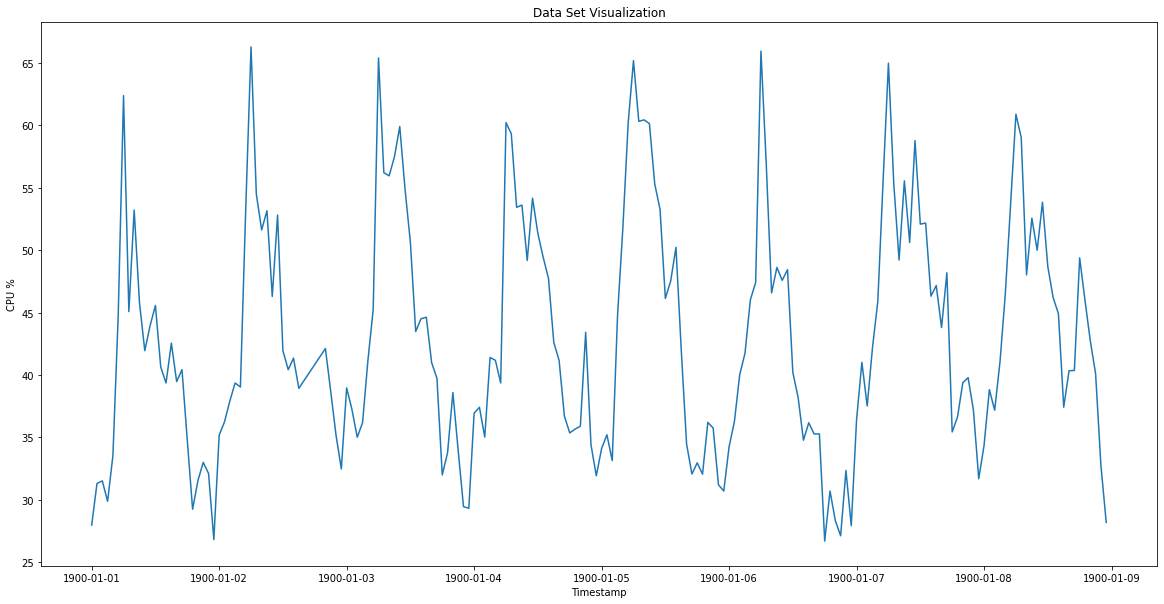

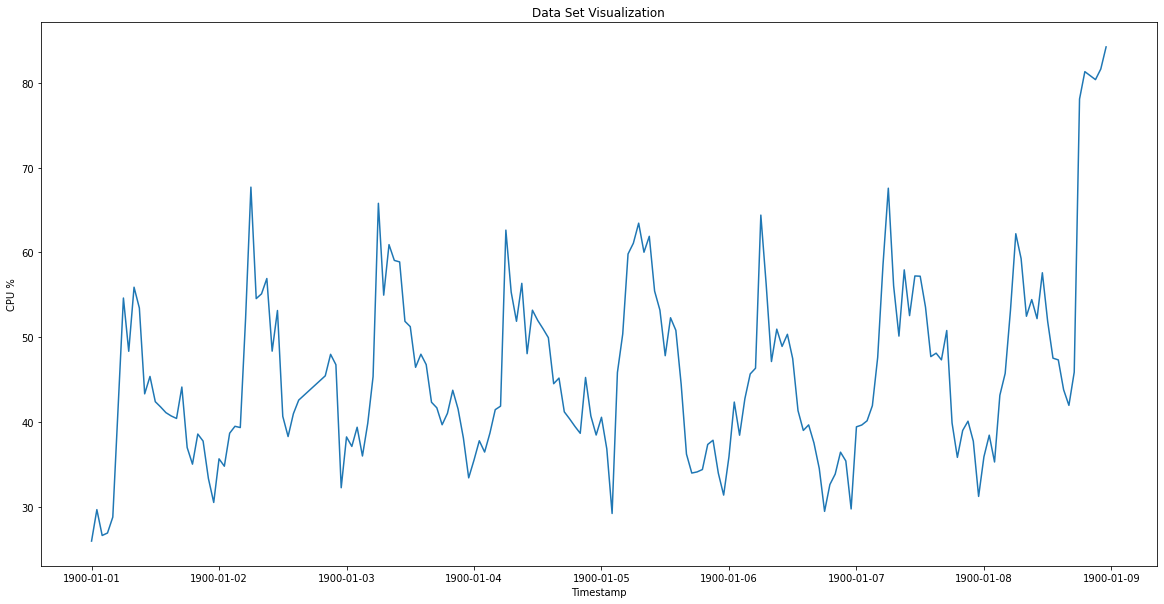

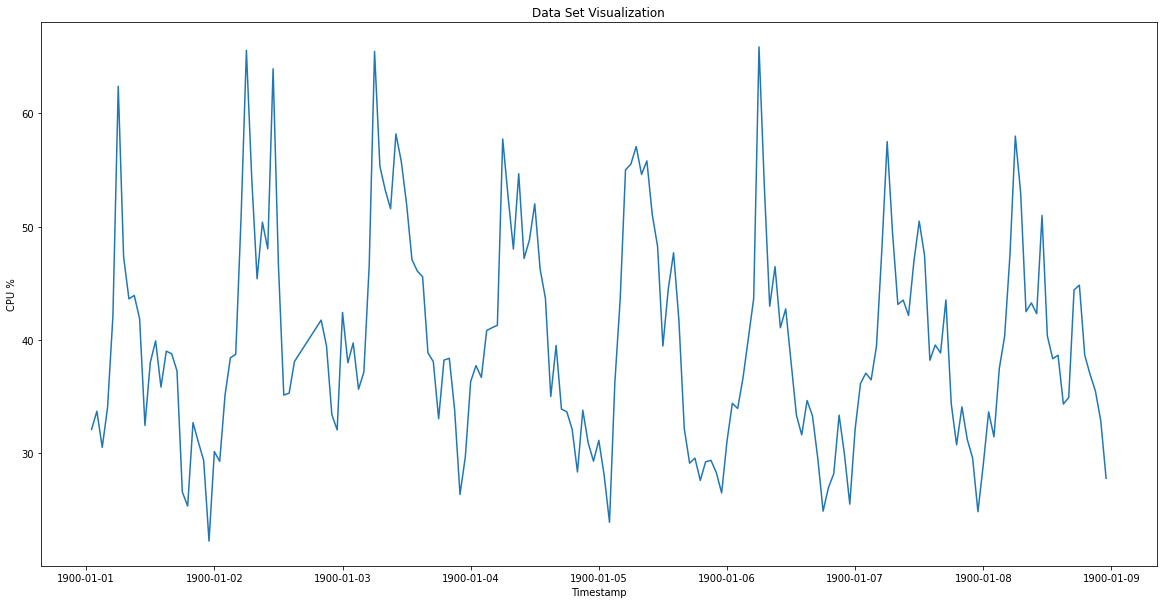

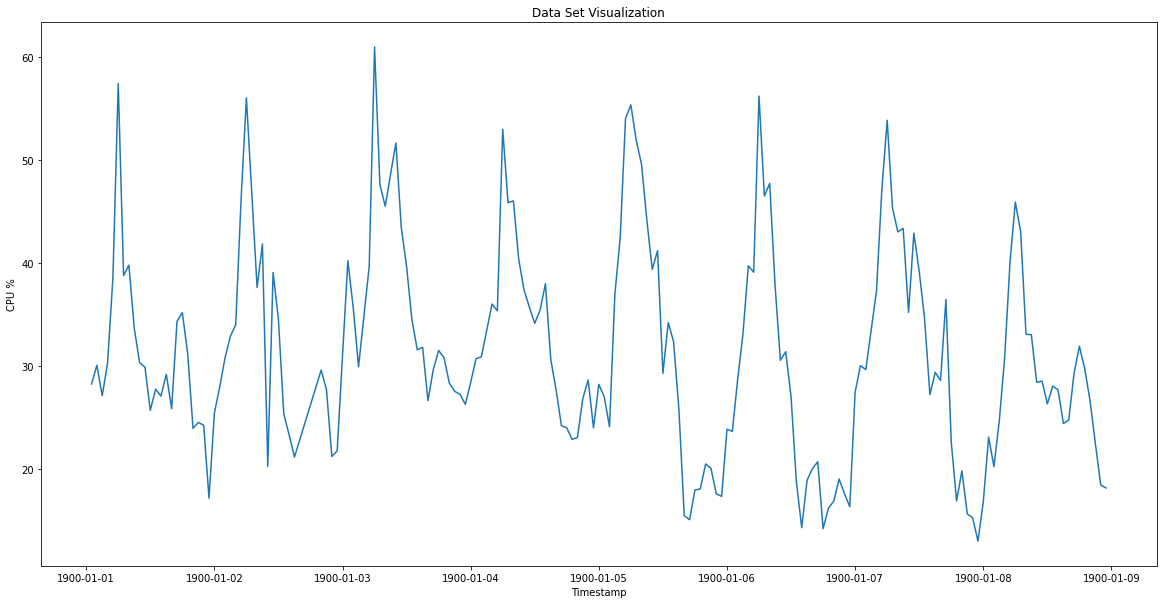

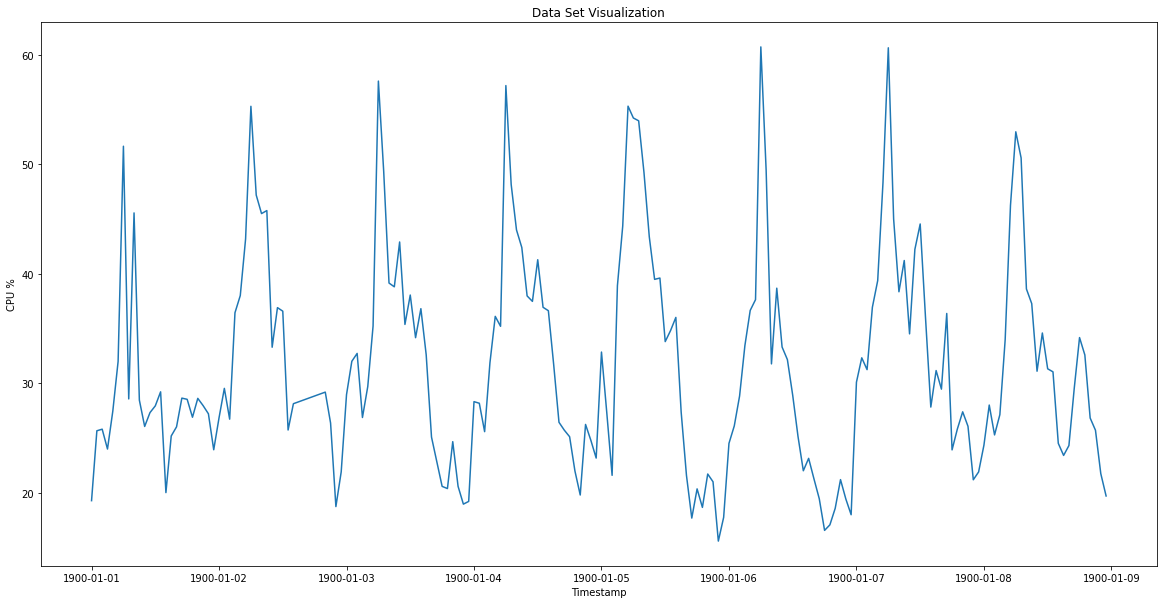

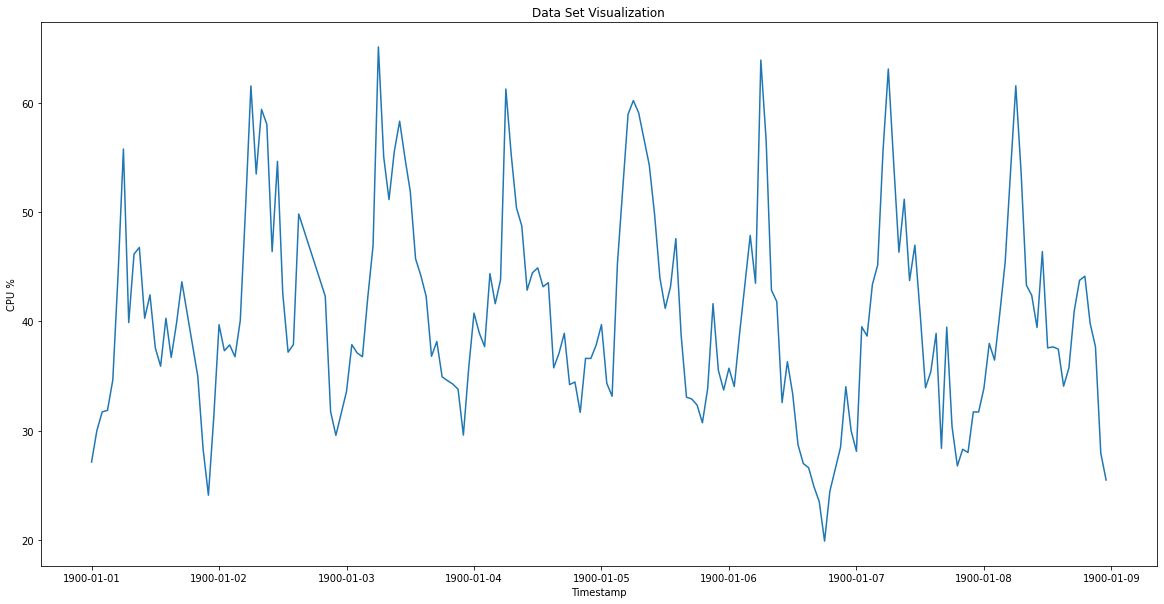

In [11]:
# Draw each data set
for df in data_re:
  plt.figure(figsize=(20,10))
  df = df.drop(df.index[0])
  plt.plot(df)
  plt.title("Data Set Visualization")
  plt.xlabel("Timestamp")
  plt.ylabel("CPU %")

# Triple Exponential Smooting (Holt-Winter)

Triple Exponential Smooting is sums level, trends, and seasonality components where each component is a weighted average with weights that increase exponentially with time. The level, trend, and seasonality components are calculated recursively as in simple exponential smoothing.





For each dataset: \\

*   Train-test split the dataset
*   Fitting the Holt-Winter model with parameters:
        smoothing_level = 0.05 
        smoothing_slope = 0.05
        smoothing_seasonal = 0.05
        seasonal = 'additive'
        seasonal_periods = 24
* Forecasting the next 48 to 49 hours


### Dataset 1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



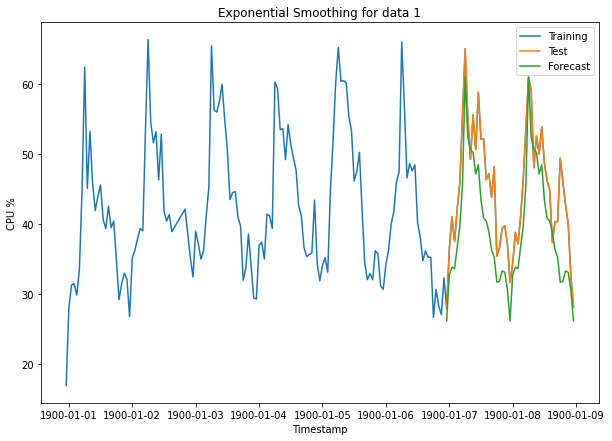

In [12]:
# Triple exponential for dx_re
seasonal_periods=[30,60,24]

# train-test split
train_dx_re, test_dx_re = np.split(dx_re, [int(.75 *len(dx_re))])

# model fit
m3_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 24)
f3_dx_re = m3_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred3_dx_re = np.exp(f3_dx_re.forecast(49))

plt.figure(figsize=(10,7))
plt.plot(dx_re['CPU %'],label='Training')
plt.plot(test_dx_re,label='Test')
plt.plot(pred3_dx_re,label='Forecast')
plt.title("Exponential Smoothing for data 1")
plt.xlabel("Timestamp")
plt.ylabel("CPU %")
plt.legend()

In [13]:
# Error metrics (root mean squared error) for triple exponential for dx_re
pred3_dx_re = pd.DataFrame(pred3_dx_re)
error_dx_re = test_dx_re.merge(pred3_dx_re, how = 'left', left_index=True, right_index=True).rename(columns={"CPU %": "Test CPU %", 0: "Predicted CPU %"})
error_dx_re['Residual'] = error_dx_re['Test CPU %'] - error_dx_re['Predicted CPU %']
rmse_exp_1 = np.sqrt(sum(error_dx_re['Residual']**2)/error_dx_re.shape[0])
rmse_exp_1

6.6826159879548195

### Dataset 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



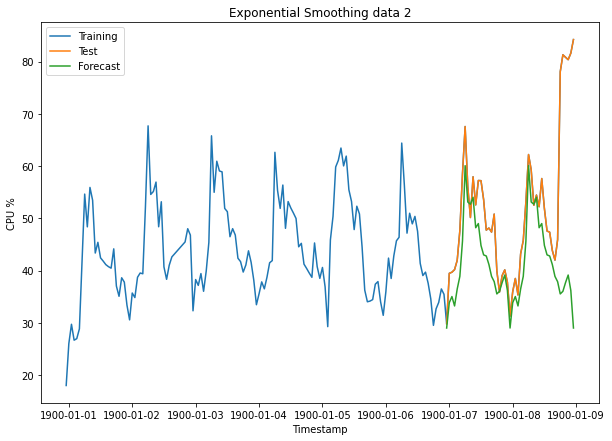

In [14]:
# Triple exponential for dx2_re
seasonal_periods=[30,60,24]

# Train-test split
train_dx_re, test_dx_re = np.split(dx2_re, [int(.75 *len(dx_re))])

# model fit
m3_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 24)
f3_dx_re = m3_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred3_dx_re = np.exp(f3_dx_re.forecast(49))

plt.figure(figsize=(10,7))
plt.plot(dx2_re['CPU %'],label='Training')
plt.plot(test_dx_re,label='Test')
plt.plot(pred3_dx_re,label='Forecast')
plt.title("Exponential Smoothing data 2")
plt.xlabel("Timestamp")
plt.ylabel("CPU %")
plt.legend()

In [15]:
# Error metrics (root mean squared error) for triple exponential for dx2_re
pred3_dx_re = pd.DataFrame(pred3_dx_re)
error_dx_re = test_dx_re.merge(pred3_dx_re, how = 'left', left_index=True, right_index=True).rename(columns={"CPU %": "Test CPU %", 0: "Predicted CPU %"})
error_dx_re['Residual'] = error_dx_re['Test CPU %'] - error_dx_re['Predicted CPU %']
rmse_exp_2 = np.sqrt(sum(error_dx_re['Residual']**2)/error_dx_re.shape[0])
rmse_exp_2

17.000510839487518

### Dataset 3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



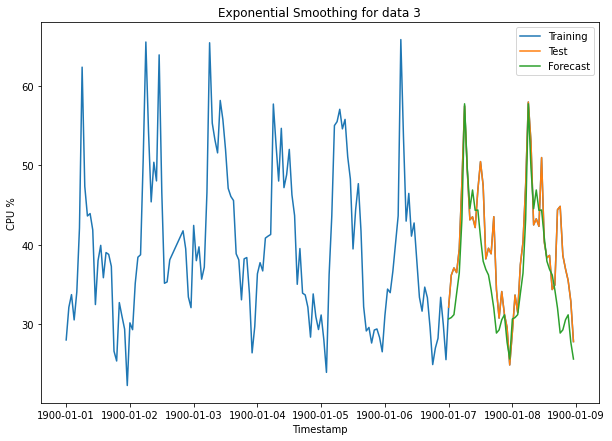

In [16]:
# Triple exponential for dx3_re
seasonal_periods=[30,60,24]

# Train-test split
train_dx_re, test_dx_re = np.split(dx3_re, [int(.75 *len(dx_re))])

# model fit
m3_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 24)
f3_dx_re = m3_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred3_dx_re = np.exp(f3_dx_re.forecast(48))

plt.figure(figsize=(10,7))
plt.plot(dx3_re['CPU %'],label='Training')
plt.plot(test_dx_re,label='Test')
plt.plot(pred3_dx_re,label='Forecast')
plt.title("Exponential Smoothing for data 3")
plt.xlabel("Timestamp")
plt.ylabel("CPU %")
plt.legend()

In [17]:
# Error metrics (root mean squared error) for triple exponential for dx3_re
pred3_dx_re = pd.DataFrame(pred3_dx_re)
error_dx_re = test_dx_re.merge(pred3_dx_re, how = 'left', left_index=True, right_index=True).rename(columns={"CPU %": "Test CPU %", 0: "Predicted CPU %"})
error_dx_re['Residual'] = error_dx_re['Test CPU %'] - error_dx_re['Predicted CPU %']
rmse_exp_3 = np.sqrt(sum(error_dx_re['Residual']**2)/error_dx_re.shape[0])
rmse_exp_3

5.114814956851405

### Dataset 4

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



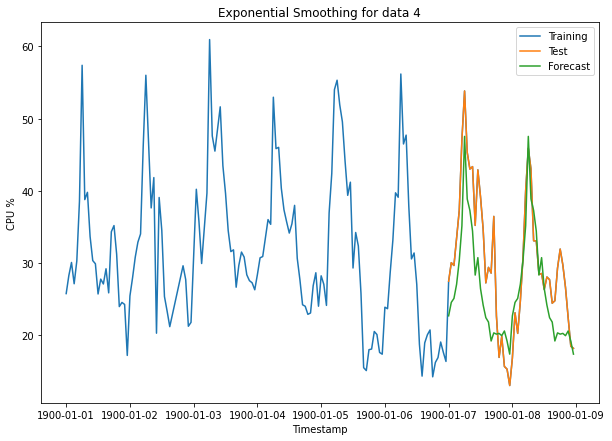

In [18]:
# Triple exponential for dx4_re
seasonal_periods=[30,60,24]

# Train-test split
train_dx_re, test_dx_re = np.split(dx4_re, [int(.75 *len(dx_re))])

# model fit
m1_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 30)
f1_dx_re = m1_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred1_dx_re = np.exp(f1_dx_re.forecast(48))

m2_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 60)
f2_dx_re = m2_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred2_dx_re = np.exp(f2_dx_re.forecast(48))

m3_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 24)
f3_dx_re = m3_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred3_dx_re = np.exp(f3_dx_re.forecast(48))

plt.figure(figsize=(10,7))
plt.plot(dx4_re['CPU %'],label='Training')
plt.plot(test_dx_re,label='Test')
#plt.plot(pred1_dx_L,label='Forecast')
#plt.plot(pred2_dx_L,label='Forecast')
plt.plot(pred3_dx_re,label='Forecast')
plt.title("Exponential Smoothing for data 4")
plt.xlabel("Timestamp")
plt.ylabel("CPU %")
plt.legend()

In [19]:
# Error metrics (root mean squared error) for triple exponential for dx4_re
pred3_dx_re = pd.DataFrame(pred3_dx_re)
error_dx_re = test_dx_re.merge(pred3_dx_re, how = 'left', left_index=True, right_index=True).rename(columns={"CPU %": "Test CPU %", 0: "Predicted CPU %"})
error_dx_re['Residual'] = error_dx_re['Test CPU %'] - error_dx_re['Predicted CPU %']
rmse_exp_4 = np.sqrt(sum(error_dx_re['Residual']**2)/error_dx_re.shape[0])
rmse_exp_4

6.527767882058208

### Dataset 5

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



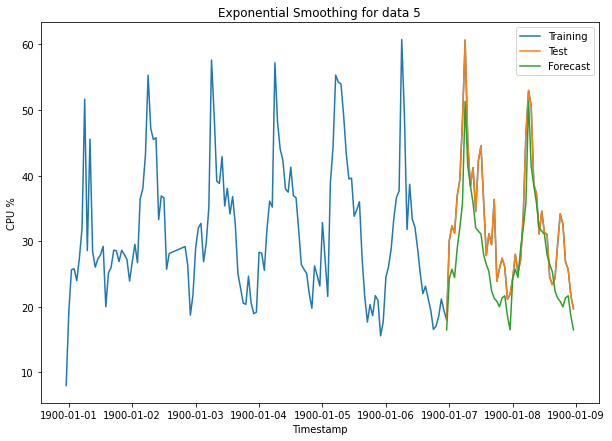

In [20]:
# Triple exponential for dx5_re
seasonal_periods=[30,60,24]

# Train-test split
train_dx_re, test_dx_re = np.split(dx5_re, [int(.75 *len(dx_re))])

# model fit
m1_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 30)
f1_dx_re = m1_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred1_dx_re = np.exp(f1_dx_re.forecast(49))

m2_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 60)
f2_dx_re = m2_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred2_dx_re = np.exp(f2_dx_re.forecast(49))

m3_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 24)
f3_dx_re = m3_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred3_dx_re = np.exp(f3_dx_re.forecast(49))

plt.figure(figsize=(10,7))
plt.plot(dx5_re['CPU %'],label='Training')
plt.plot(test_dx_re,label='Test')
#plt.plot(pred1_dx_L,label='Forecast')
#plt.plot(pred2_dx_L,label='Forecast')
plt.plot(pred3_dx_re,label='Forecast')
plt.title("Exponential Smoothing for data 5")
plt.xlabel("Timestamp")
plt.ylabel("CPU %")
plt.legend()

In [21]:
# Error metrics (root mean squared error) for triple exponential for dx5_re
pred3_dx_re = pd.DataFrame(pred3_dx_re)
error_dx_re = test_dx_re.merge(pred3_dx_re, how = 'left', left_index=True, right_index=True).rename(columns={"CPU %": "Test CPU %", 0: "Predicted CPU %"})
error_dx_re['Residual'] = error_dx_re['Test CPU %'] - error_dx_re['Predicted CPU %']
rmse_exp_5 = np.sqrt(sum(error_dx_re['Residual']**2)/error_dx_re.shape[0])
rmse_exp_5

6.474685800161645

### Dataset 6

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



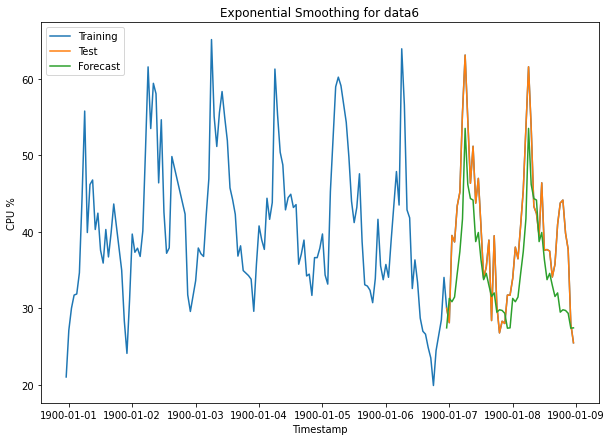

In [22]:
# Triple exponential for dx6_re
seasonal_periods=[30,60,24]

# Train-test split
train_dx_re, test_dx_re = np.split(dx6_re, [int(.75 *len(dx_re))])

# model fit
m1_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 30)
f1_dx_re = m1_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred1_dx_re = np.exp(f1_dx_re.forecast(49))

m2_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 60)
f2_dx_re = m2_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred2_dx_re = np.exp(f2_dx_re.forecast(49))

m3_dx_re = ExponentialSmoothing(np.log(train_dx_re['CPU %']), seasonal = 'additive', seasonal_periods = 24)
f3_dx_re = m3_dx_re.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
pred3_dx_re = np.exp(f3_dx_re.forecast(49))

plt.figure(figsize=(10,7))
plt.plot(dx6_re['CPU %'],label='Training')
plt.plot(test_dx_re,label='Test')
#plt.plot(pred1_dx_L,label='Forecast')
#plt.plot(pred2_dx_L,label='Forecast')
plt.plot(pred3_dx_re,label='Forecast')
plt.title("Exponential Smoothing for data6")
plt.xlabel("Timestamp")
plt.ylabel("CPU %")
plt.legend()

In [23]:
# Error metrics (root mean squared error) for triple exponential for dx6_re
pred3_dx_re = pd.DataFrame(pred3_dx_re)
error_dx_re = test_dx_re.merge(pred3_dx_re, how = 'left', left_index=True, right_index=True).rename(columns={"CPU %": "Test CPU %", 0: "Predicted CPU %"})
error_dx_re['Residual'] = error_dx_re['Test CPU %'] - error_dx_re['Predicted CPU %']
rmse_exp_6 = np.sqrt(sum(error_dx_re['Residual']**2)/error_dx_re.shape[0])
rmse_exp_6

6.617911835792671

In [24]:
# Summary error metrics rsme for holt winter
model_errors_exp = pd.DataFrame({
    "Data": ['data 1', 'data 2','data 3','data 4','data 5','data 6',],
    "RMSE": [rmse_exp_1, rmse_exp_2, rmse_exp_3, rmse_exp_4, rmse_exp_5, rmse_exp_6]
})

model_errors_exp

,Data,RMSE
0,data 1,6.682616
1,data 2,17.000511
2,data 3,5.114815
3,data 4,6.527768
4,data 5,6.474686
5,data 6,6.617912


# SARIMA

Sarima fits a regression model on previous observations, error terms, and differencing, and adds terms to account for the seasonal components. It also allows observations from previous years to be added to the model.

For each dataset:

*   we found the optimal parameters using a seasonal period of 24 hours and based on the AIC criterion
*   fit the model with the optimal parameters
*   create forecasts
*   compare the prediction with the test data



### Dataset 1

In [25]:
# sarima seasonal period s=24
train_dx_I, test_dx_I = np.split(dx_re, [int(.75 *len(dx_re))])

# finding optimal parameters
(auto_arima(np.log(train_dx_I["CPU %"]),
           seasonal=True,
           m=24,                        
           d=1,                          
           information_criterion='aicc').
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 24)   Log Likelihood                 113.199
Date:                              Thu, 10 Dec 2020   AIC                           -212.398
Time:                                      19:16:28   BIC                           -191.658
Sample:                                           0   HQIC                          -203.970
                                              - 144                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1978      0.501     -0.395      0.693      -1.179       0.783
ar.L2          0.6016      0.285      2.111      0.035       0.043       1.160
ma.L1         -0.0832      0.514     -0.162      0.871      -1.091       0.924
ma.L2         -0.8046      0.465     -1.731      0.084      -1.716       0.107
ar.S.L24       0.9392      0.049     19.358      0.000       0.844       1.034
ma.S.L24      -0.6150      0.164     -3.739      0.000      -0.937      -0.293
sigma2         0.0103      0.001      7.674      0.000       0.008       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 8.91
Prob(Q):                              0.72   Prob(JB):                         0.01
Heteroskedasticity (H):               0.85   Skew:                             0.44
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0.5, 1.0, 'SARIMA (1,1,2) (1,0,1) [24]')

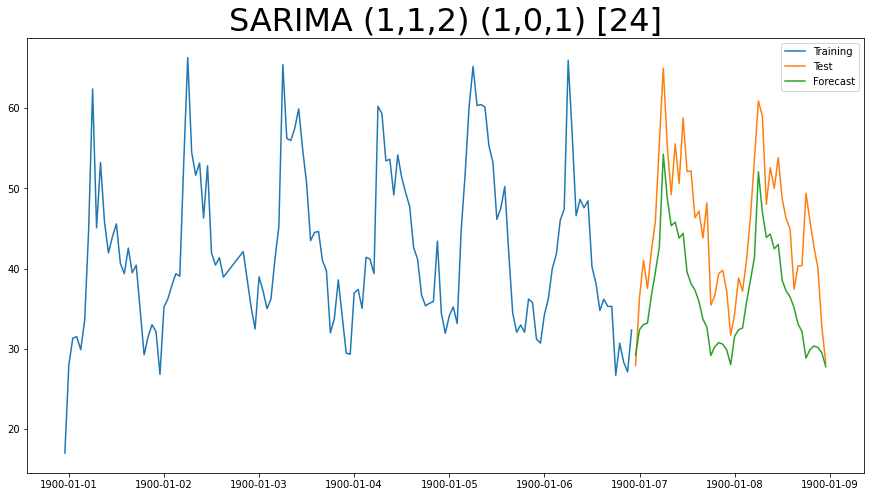

In [26]:
# model fit
model_sarima_dx = SARIMAX(np.log(train_dx_I["CPU %"]), order=(1,1,2), seasonal_order=(1,0,1,24)).fit()

start = len(train_dx_I)
end = len(train_dx_I) +len(test_dx_I) -1

# Create forecasts
sarima_dx = np.exp(model_sarima_dx.predict(start, end))

# Plot forecast, test set, and training set
plt.figure(figsize=(15,8))

plt.plot(train_dx_I['CPU %'], label='Training')
plt.legend(loc='best')

plt.plot(test_dx_I['CPU %'],label='Test')
plt.legend(loc='best')

plt.plot(sarima_dx, label='Forecast')
plt.legend(loc='best')

plt.title('SARIMA (1,1,2) (1,0,1) [24]', fontsize=32)

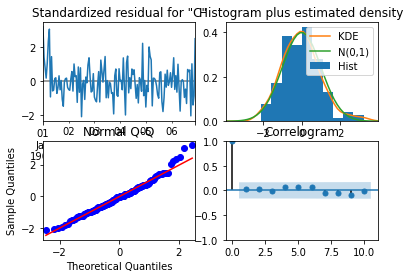

In [27]:
# residual check
model_sarima_dx.plot_diagnostics();

In [28]:
# Error metrics: root mean squared error
sarima_rmse_1 = np.round(rmse(test_dx_I['CPU %'], sarima_dx),2)
sarima_rmse_1

9.25

### Dataset 2

In [29]:
# sarima seasonal period s=24
train_dx2_I, test_dx2_I = np.split(dx2_re, [int(.75 *len(dx2_re))])

# finding optimal parameters
(auto_arima(np.log(train_dx2_I["CPU %"]),
           seasonal=True,
           m=24,                        
           d=1,                          
           information_criterion='aicc').
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood                 117.921
Date:                            Thu, 10 Dec 2020   AIC                           -225.843
Time:                                    19:20:31   BIC                           -211.028
Sample:                                         0   HQIC                          -219.823
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6640      0.092      7.237      0.000       0.484       0.844
ma.L1         -0.9154      0.066    -13.875      0.000      -1.045      -0.786
ar.S.L24       0.9329      0.048     19.299      0.000       0.838       1.028
ma.S.L24      -0.6080      0.160     -3.792      0.000      -0.922      -0.294
sigma2         0.0098      0.001      9.171      0.000       0.008       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                18.12
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.48
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'SARIMA (1,1,1) (1,0,1) [24]')

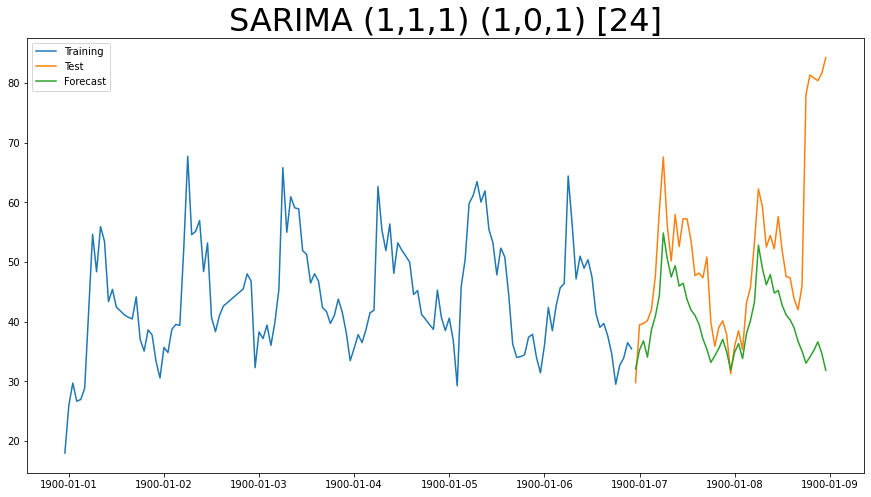

In [30]:
# model fit
model_sarima_dx2 = SARIMAX(np.log(train_dx2_I["CPU %"]), order=(1,1,1), seasonal_order=(1,0,1,24)).fit()

start = len(train_dx2_I)
end = len(train_dx2_I) +len(test_dx2_I) -1

# Create forecasts
sarima_dx2 = np.exp(model_sarima_dx2.predict(start, end))


# Plot forecast, test set, and training set
plt.figure(figsize=(15,8))

plt.plot(train_dx2_I['CPU %'], label='Training')
plt.legend(loc='best')

plt.plot(test_dx2_I['CPU %'],label='Test')
plt.legend(loc='best')

plt.plot(sarima_dx2, label='Forecast')
plt.legend(loc='best')

plt.title('SARIMA (1,1,1) (1,0,1) [24]', fontsize=32)

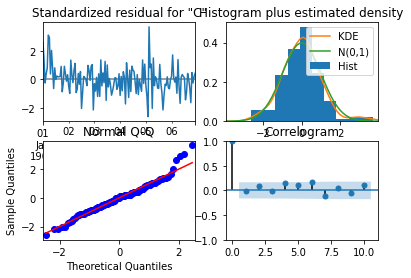

In [31]:
# residual check
model_sarima_dx2.plot_diagnostics();

In [32]:
# Error metrics: root mean squared error
sarima_rmse_2 = np.round(rmse(test_dx2_I['CPU %'], sarima_dx2),2)
sarima_rmse_2

17.96

### Dataset 3

In [33]:
# sarima seasonal period s=24
train_dx3_I, test_dx3_I = np.split(dx3_re, [int(.75 *len(dx3_re))])

(auto_arima(np.log(train_dx3_I["CPU %"]),
           seasonal=True,
           m=24,                        
           d=1,                          
           information_criterion='aicc').
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(0, 1, 3)x(2, 0, [1], 24)   Log Likelihood                  93.526
Date:                              Thu, 10 Dec 2020   AIC                           -171.052
Time:                                      19:23:55   BIC                           -147.349
Sample:                                           0   HQIC                          -161.421
                                              - 144                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.564e-05      0.000     -0.120      0.904      -0.000       0.000
ma.L1         -0.2529      0.082     -3.103      0.002      -0.413      -0.093
ma.L2         -0.2549      0.082     -3.094      0.002      -0.416      -0.093
ma.L3         -0.3000      0.109     -2.763      0.006      -0.513      -0.087
ar.S.L24       0.7658      0.270      2.835      0.005       0.236       1.295
ar.S.L48       0.1907      0.206      0.925      0.355      -0.213       0.595
ma.S.L24      -0.6543      0.343     -1.908      0.056      -1.326       0.018
sigma2         0.0131      0.002      7.319      0.000       0.010       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.14
Prob(Q):                              0.78   Prob(JB):                         0.13
Heteroskedasticity (H):               0.76   Skew:                             0.30
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0.5, 1.0, 'SARIMA (3,1,2) (1,0,1) [24]')

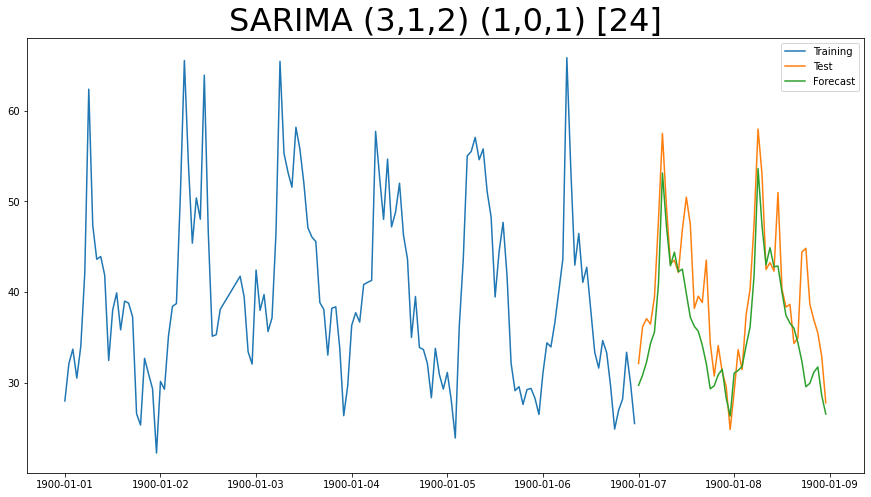

In [34]:
# model fit
model_sarima_dx3 = SARIMAX(np.log(train_dx3_I["CPU %"]), order=(3,1,2), seasonal_order=(1,0,1,24)).fit()

start = len(train_dx3_I)
end = len(train_dx3_I) +len(test_dx3_I) -1

# Create forecasts
sarima_dx3 = np.exp(model_sarima_dx3.predict(start, end))


# Plot forecast, test set, and training set
plt.figure(figsize=(15,8))

plt.plot(train_dx3_I['CPU %'], label='Training')
plt.legend(loc='best')

plt.plot(test_dx3_I['CPU %'],label='Test')
plt.legend(loc='best')

plt.plot(sarima_dx3, label='Forecast')
plt.legend(loc='best')

plt.title('SARIMA (3,1,2) (1,0,1) [24]', fontsize=32)

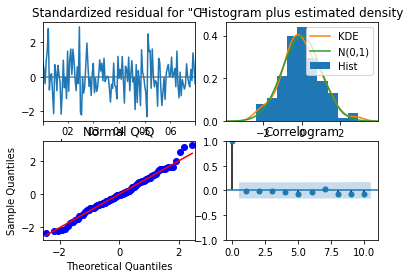

In [35]:
# residual check
model_sarima_dx3.plot_diagnostics();

In [36]:
# Error metrics: root mean squared error
sarima_rmse_3 = np.round(rmse(test_dx3_I['CPU %'], sarima_dx3),2)
sarima_rmse_3

5.25

### Dataset 4

In [37]:
# sarima seasonal period s=24
train_dx4_I, test_dx4_I = np.split(dx4_re, [int(.75 *len(dx4_re))])

# finding optimal parameters
(auto_arima(np.log(train_dx4_I["CPU %"]),
           seasonal=True,
           m=24,                        
           d=1,                          
           information_criterion='aicc').
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 24)   Log Likelihood                  47.731
Date:                             Thu, 10 Dec 2020   AIC                            -85.462
Time:                                     19:25:50   BIC                            -70.647
Sample:                                          0   HQIC                           -79.442
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7321      0.077      9.452      0.000       0.580       0.884
ma.L1         -0.9744      0.044    -22.171      0.000      -1.061      -0.888
ar.S.L24       0.2467      0.084      2.946      0.003       0.083       0.411
ar.S.L48       0.3135      0.107      2.934      0.003       0.104       0.523
sigma2         0.0282      0.003      9.166      0.000       0.022       0.034
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                14.15
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.23
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'SARIMA (1,1,1) (2,0,0) [24]')

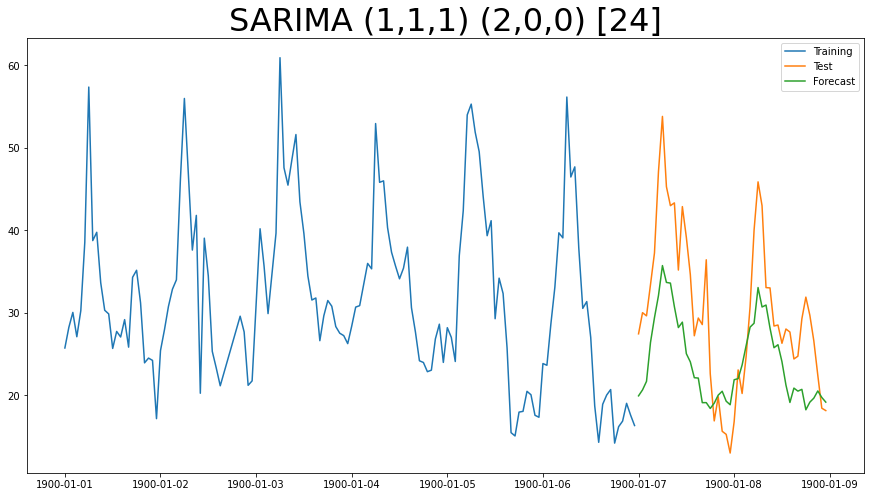

In [38]:
# model fit
model_sarima_dx4 = SARIMAX(np.log(train_dx4_I["CPU %"]), order=(1,1,1), seasonal_order=(2,0,0,24)).fit()

start = len(train_dx4_I)
end = len(train_dx4_I) +len(test_dx4_I) -1

# Create forecasts
sarima_dx4 = np.exp(model_sarima_dx4.predict(start, end))


# Plot forecast, test set, and training set
plt.figure(figsize=(15,8))

plt.plot(train_dx4_I['CPU %'], label='Training')
plt.legend(loc='best')

plt.plot(test_dx4_I['CPU %'],label='Test')
plt.legend(loc='best')

plt.plot(sarima_dx4, label='Forecast')
plt.legend(loc='best')

plt.title('SARIMA (1,1,1) (2,0,0) [24]', fontsize=32)

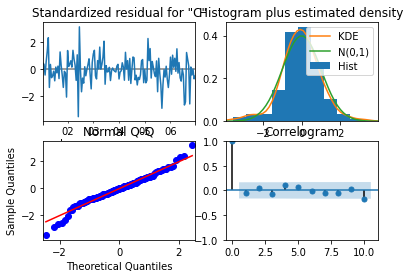

In [39]:
# residual check
model_sarima_dx4.plot_diagnostics();

In [40]:
# Error metrics: root mean squared error
sarima_rmse_4 = np.round(rmse(test_dx4_I['CPU %'], sarima_dx4),2)
sarima_rmse_4

8.52

### Dataset 5

In [41]:
# sarima seasonal period s=24
train_dx5_I, test_dx5_I = np.split(dx5_re, [int(.75 *len(dx5_re))])

# finding optimal parameters
(auto_arima(np.log(train_dx5_I["CPU %"]),
           seasonal=True,
           m=24,                        
           d=1,                          
           information_criterion='aicc').
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 24)   Log Likelihood                  42.714
Date:                            Thu, 10 Dec 2020   AIC                            -77.427
Time:                                    19:29:12   BIC                            -65.576
Sample:                                         0   HQIC                           -72.612
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3531      0.063     -5.587      0.000      -0.477      -0.229
ar.S.L24       0.9646      0.059     16.443      0.000       0.850       1.080
ma.S.L24      -0.7610      0.203     -3.744      0.000      -1.159      -0.363
sigma2         0.0279      0.004      7.046      0.000       0.020       0.036
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                13.54
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.36
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'SARIMA (0,1,1) (1,0,1) [24]')

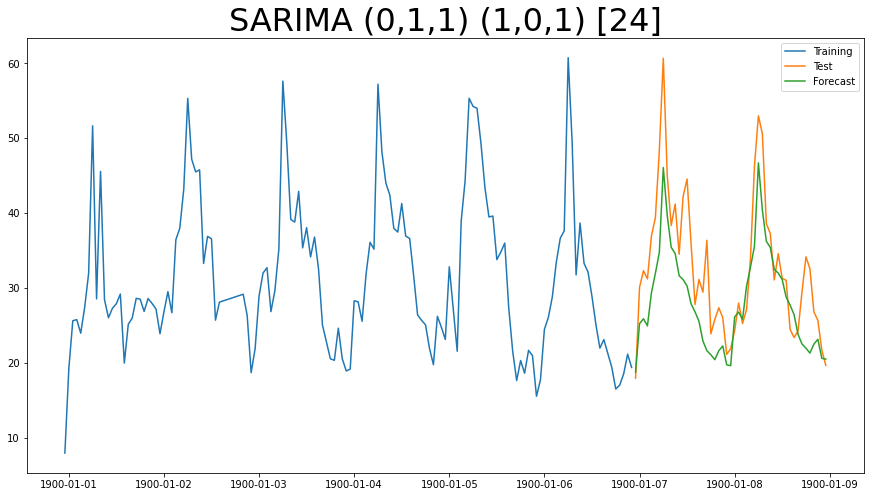

In [42]:
# model fit
model_sarima_dx5 = SARIMAX(np.log(train_dx5_I["CPU %"]), order=(0,1,1), seasonal_order=(1,0,1,24)).fit()

start = len(train_dx5_I)
end = len(train_dx5_I) +len(test_dx5_I) -1

# Create forecasts
sarima_dx5 = np.exp(model_sarima_dx5.predict(start, end))


# Plot forecast, test set, and training set
plt.figure(figsize=(15,8))

plt.plot(train_dx5_I['CPU %'], label='Training')
plt.legend(loc='best')

plt.plot(test_dx5_I['CPU %'],label='Test')
plt.legend(loc='best')

plt.plot(sarima_dx5, label='Forecast')
plt.legend(loc='best')

plt.title('SARIMA (0,1,1) (1,0,1) [24]', fontsize=32)

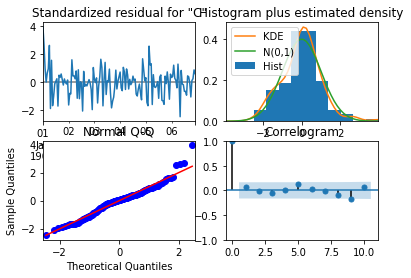

In [43]:
# residual check
model_sarima_dx5.plot_diagnostics();

In [44]:
# Error metrics: root mean squared error
sarima_rmse_5 = np.round(rmse(test_dx5_I['CPU %'], sarima_dx5),2)
sarima_rmse_5

6.62

### Dataset 6

In [45]:
# sarima seasonal period s=24
train_dx6_I, test_dx6_I = np.split(dx6_re, [int(.75 *len(dx6_re))])

# finding optimal parameters
(auto_arima(np.log(train_dx6_I["CPU %"]),
           seasonal=True,
           m=24,                        
           d=1,                          
           information_criterion='aicc').
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 24)   Log Likelihood                 105.876
Date:                             Thu, 10 Dec 2020   AIC                           -201.751
Time:                                     19:31:10   BIC                           -186.937
Sample:                                          0   HQIC                          -195.731
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7538      0.077      9.806      0.000       0.603       0.904
ma.L1         -0.9546      0.035    -27.239      0.000      -1.023      -0.886
ar.S.L24       0.3733      0.085      4.379      0.000       0.206       0.540
ar.S.L48       0.2909      0.082      3.542      0.000       0.130       0.452
sigma2         0.0122      0.002      7.175      0.000       0.009       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.85   Prob(JB):                         0.26
Heteroskedasticity (H):               1.14   Skew:                             0.27
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Text(0.5, 1.0, 'SARIMA (1,1,1) (2,0,0) [24]')

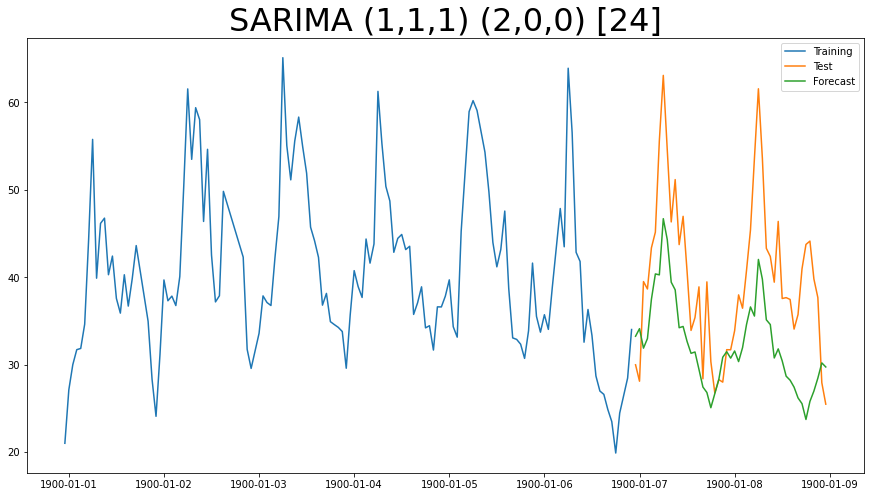

In [46]:
# model fit
model_sarima_dx6 = SARIMAX(np.log(train_dx6_I["CPU %"]), order=(1,1,1), seasonal_order=(2,0,0,24)).fit()

start = len(train_dx6_I)
end = len(train_dx6_I) +len(test_dx6_I) -1

# Create forecasts
sarima_dx6 = np.exp(model_sarima_dx6.predict(start, end))


# Plot forecast, test set, and training set
plt.figure(figsize=(15,8))

plt.plot(train_dx6_I['CPU %'], label='Training')
plt.legend(loc='best')

plt.plot(test_dx6_I['CPU %'],label='Test')
plt.legend(loc='best')

plt.plot(sarima_dx6, label='Forecast')
plt.legend(loc='best')

plt.title('SARIMA (1,1,1) (2,0,0) [24]', fontsize=32)

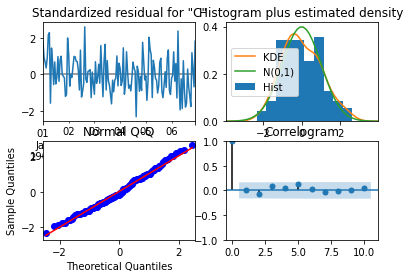

In [47]:
# residual check
model_sarima_dx6.plot_diagnostics();

In [48]:
# Error metrics: root mean squared error
sarima_rmse_6 = np.round(rmse(test_dx6_I['CPU %'], sarima_dx6),2)
sarima_rmse_6

9.85

In [49]:
# Summary error metrics SARIMA
model_errors_sarima = pd.DataFrame({
    "Model": ['SARIMA (1,1,2) (1,0,1) [24]', 'SARIMA (1,1,1) (1,0,1) [24]', 'SARIMA (3,1,2) (1,0,1) [24]', 'SARIMA (1,1,1) (2,0,0) [24]',
              'SARIMA (0,1,1) (1,0,1) [24]', 'SARIMA (1,1,1) (2,0,0) [24]'],
    "RMSE": [sarima_rmse_1, sarima_rmse_2, sarima_rmse_3, sarima_rmse_4, sarima_rmse_5, sarima_rmse_6]
})

model_errors_sarima

,Model,RMSE
0,"SARIMA (1,1,2) (1,0,1) [24]",9.25
1,"SARIMA (1,1,1) (1,0,1) [24]",17.96
2,"SARIMA (3,1,2) (1,0,1) [24]",5.25
3,"SARIMA (1,1,1) (2,0,0) [24]",8.52
4,"SARIMA (0,1,1) (1,0,1) [24]",6.62
5,"SARIMA (1,1,1) (2,0,0) [24]",9.85


# Prophet

The model Prophet was fit with the following parameters:

*   daily_seasonality=True
*   seasonality_mode="additive"

With datasets that have special events such as peak events or holidays, the model can incorporate them very well.


### Dataset 1

In [50]:
# train-test split
dx_fb = dx_re.reset_index()
dx_fb.columns=['ds','y']   
train_fb_dx, test_fb_dx = np.split(dx_fb, [int(.75 *len(dx_fb))])


In [51]:
# fit model
fb1_model=Prophet(weekly_seasonality=False,
           daily_seasonality=True, 
           n_changepoints=10, 
           seasonality_mode="additive").fit(train_fb_dx) 

#Prophet results are saved to a dataframe using make_future_dataframe()
fb1_df=fb1_model.make_future_dataframe(48, freq='60T') 

fb1_fc_df=fb1_model.predict(fb1_df)[["ds","yhat"]]


fb1_fc = fb1_fc_df.iloc[-len(test_dx_I):]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


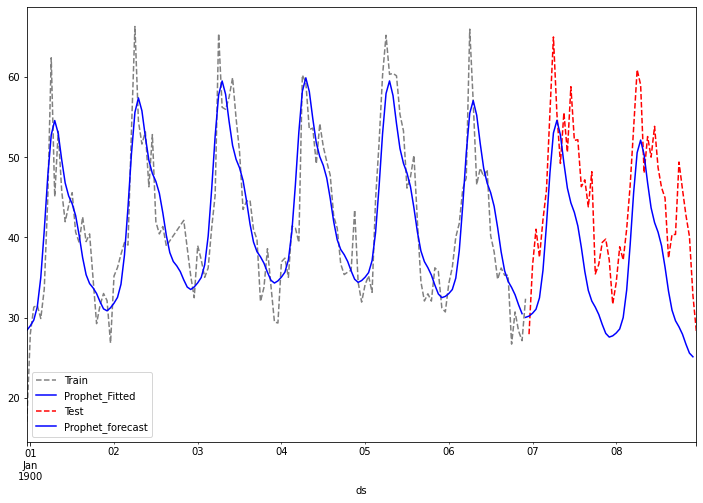

In [52]:

train_dx_I["CPU %"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")

fb1_fc_df.set_index('ds')["yhat"].iloc[:-len(test_dx_I)].plot(color="b", legend=True, label="Prophet_Fitted")

test_dx_I["CPU %"].plot(style="--",color="r", legend=True, label="Test")

fb1_fc_df.set_index('ds')["yhat"].iloc[-len(test_dx_I):].plot(color="b", legend=True, label="Prophet_forecast");

In [53]:
# Error metrics: root mean squared error
fb_rmse = np.round(rmse(test_dx_I["CPU %"], fb1_fc["yhat"].values),2)
fb_rmse

9.6

### Dataset 2

In [54]:
# train-test split
dx2_fb = dx2_re.reset_index()
dx2_fb.columns=['ds','y']   
train_fb_dx2, test_fb_dx2 = np.split(dx2_fb, [int(.75 *len(dx2_fb))])

In [55]:
# model fit
fb2_model=Prophet(weekly_seasonality=False,
           daily_seasonality=True, 
           n_changepoints=10, 
           seasonality_mode="additive").fit(train_fb_dx2) 

#Prophet results are saved to a dataframe using make_future_dataframe()
fb2_df=fb2_model.make_future_dataframe(48, freq='60T') 

fb2_fc_df=fb2_model.predict(fb2_df)[["ds","yhat"]]


fb2_fc = fb2_fc_df.iloc[-len(test_dx2_I):]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


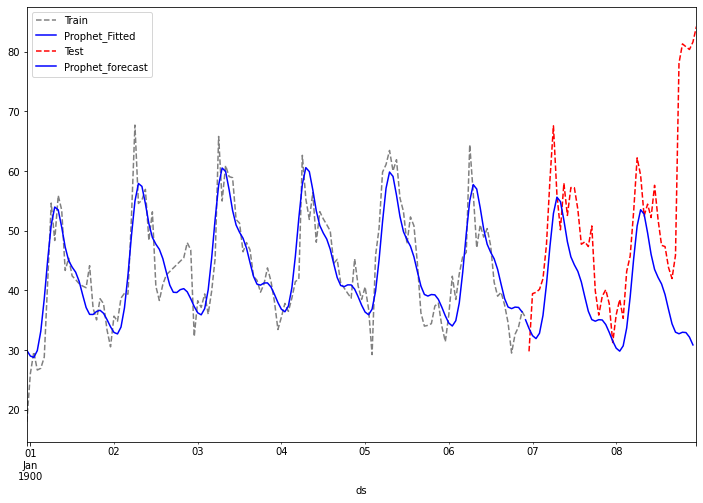

In [56]:
train_dx2_I["CPU %"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")

fb2_fc_df.set_index('ds')["yhat"].iloc[:-len(test_dx2_I)].plot(color="b", legend=True, label="Prophet_Fitted")

test_dx2_I["CPU %"].plot(style="--",color="r", legend=True, label="Test")

fb2_fc_df.set_index('ds')["yhat"].iloc[-len(test_dx2_I):].plot(color="b", legend=True, label="Prophet_forecast");

In [57]:
# Error metrics: root mean squared error
fb_rmse2 = np.round(rmse(test_dx2_I["CPU %"], fb2_fc["yhat"].values),2)
fb_rmse2

18.92

### Dataset 3

In [58]:
# train-test split
dx3_fb = dx3_re.reset_index()
dx3_fb.columns=['ds','y']   
train_fb_dx3, test_fb_dx3 = np.split(dx3_fb, [int(.75 *len(dx3_fb))])

In [59]:
# model fit
fb3_model=Prophet(weekly_seasonality=False,
           daily_seasonality=True, 
           n_changepoints=10, 
           seasonality_mode="additive").fit(train_fb_dx3) 

#Prophet results are saved to a dataframe using make_future_dataframe()
fb3_df=fb3_model.make_future_dataframe(48, freq='60T') 

fb3_fc_df=fb3_model.predict(fb3_df)[["ds","yhat"]]


fb3_fc = fb3_fc_df.iloc[-len(test_dx3_I):]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


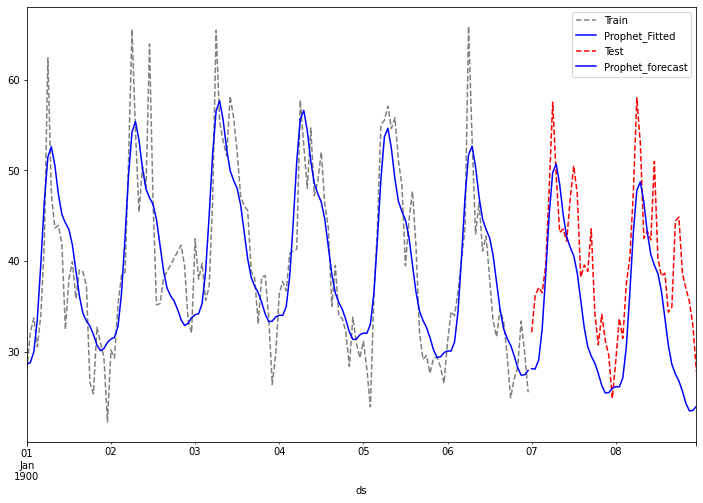

In [60]:
train_dx3_I["CPU %"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")

fb3_fc_df.set_index('ds')["yhat"].iloc[:-len(test_dx3_I)].plot(color="b", legend=True, label="Prophet_Fitted")

test_dx3_I["CPU %"].plot(style="--",color="r", legend=True, label="Test")

fb3_fc_df.set_index('ds')["yhat"].iloc[-len(test_dx3_I):].plot(color="b", legend=True, label="Prophet_forecast");



In [61]:
# Error metrics: root mean squared error
fb_rmse3 = np.round(rmse(test_dx3_I["CPU %"], fb3_fc["yhat"].values),2)
fb_rmse3

7.43

### Dataset 4

In [62]:
# train-test split
dx4_fb = dx4_re.reset_index()
dx4_fb.columns=['ds','y']   
train_fb_dx4, test_fb_dx4 = np.split(dx4_fb, [int(.75 *len(dx4_fb))])

In [63]:
# model fit
fb4_model=Prophet(weekly_seasonality=False,
           daily_seasonality=True, 
           n_changepoints=10, 
           seasonality_mode="additive").fit(train_fb_dx4) 

#Prophet results are saved to a dataframe using make_future_dataframe()
fb4_df=fb4_model.make_future_dataframe(48, freq='60T') 

fb4_fc_df=fb4_model.predict(fb4_df)[["ds","yhat"]]


fb4_fc = fb4_fc_df.iloc[-len(test_dx4_I):]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


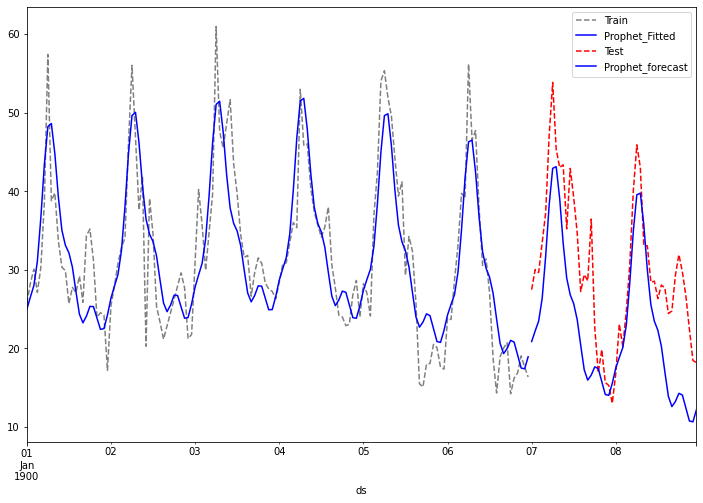

In [64]:
train_dx4_I["CPU %"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")

fb4_fc_df.set_index('ds')["yhat"].iloc[:-len(test_dx4_I)].plot(color="b", legend=True, label="Prophet_Fitted")

test_dx4_I["CPU %"].plot(style="--",color="r", legend=True, label="Test")

fb4_fc_df.set_index('ds')["yhat"].iloc[-len(test_dx4_I):].plot(color="b", legend=True, label="Prophet_forecast");

In [65]:
# Error metrics: root mean squared error
fb_rmse4 = np.round(rmse(test_dx4_I["CPU %"], fb4_fc["yhat"].values),2)
fb_rmse4

8.89

### Dataset 5

In [66]:
# train-test split
dx5_fb = dx5_re.reset_index()
dx5_fb.columns=['ds','y']   
train_fb_dx5, test_fb_dx5 = np.split(dx5_fb, [int(.75 *len(dx5_fb))])

In [67]:
# model fit
fb5_model=Prophet(weekly_seasonality=False,
           daily_seasonality=True, 
           n_changepoints=10, 
           seasonality_mode="additive").fit(train_fb_dx5) 

#Prophet results are saved to a dataframe using make_future_dataframe()
fb5_df=fb5_model.make_future_dataframe(48, freq='60T') 

fb5_fc_df=fb5_model.predict(fb5_df)[["ds","yhat"]]


fb5_fc = fb5_fc_df.iloc[-len(test_dx5_I):]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


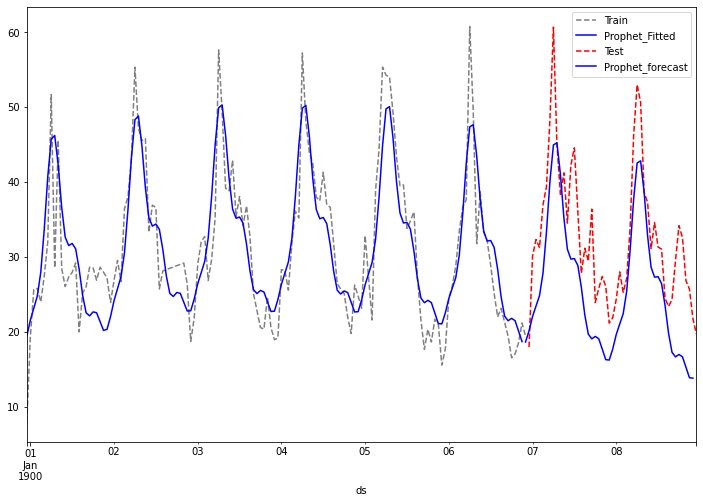

In [68]:
train_dx5_I["CPU %"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")

fb5_fc_df.set_index('ds')["yhat"].iloc[:-len(test_dx5_I)].plot(color="b", legend=True, label="Prophet_Fitted")

test_dx5_I["CPU %"].plot(style="--",color="r", legend=True, label="Test")

fb5_fc_df.set_index('ds')["yhat"].iloc[-len(test_dx5_I):].plot(color="b", legend=True, label="Prophet_forecast");

In [69]:
# Error metrics: root mean squared error
fb_rmse5 = np.round(rmse(test_dx5_I["CPU %"], fb5_fc["yhat"].values),2)
fb_rmse5

9.17

### Dataset 6

In [70]:
# train-test split
dx6_fb = dx6_re.reset_index()
dx6_fb.columns=['ds','y']   
train_fb_dx6, test_fb_dx6 = np.split(dx6_fb, [int(.75 *len(dx6_fb))])

In [71]:
# model fit
fb6_model=Prophet(weekly_seasonality=False,
           daily_seasonality=True, 
           n_changepoints=10, 
           seasonality_mode="additive").fit(train_fb_dx6) 

#Prophet results are saved to a dataframe using make_future_dataframe()
fb6_df=fb6_model.make_future_dataframe(48, freq='60T') 

fb6_fc_df=fb6_model.predict(fb6_df)[["ds","yhat"]]


fb6_fc = fb6_fc_df.iloc[-len(test_dx6_I):]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


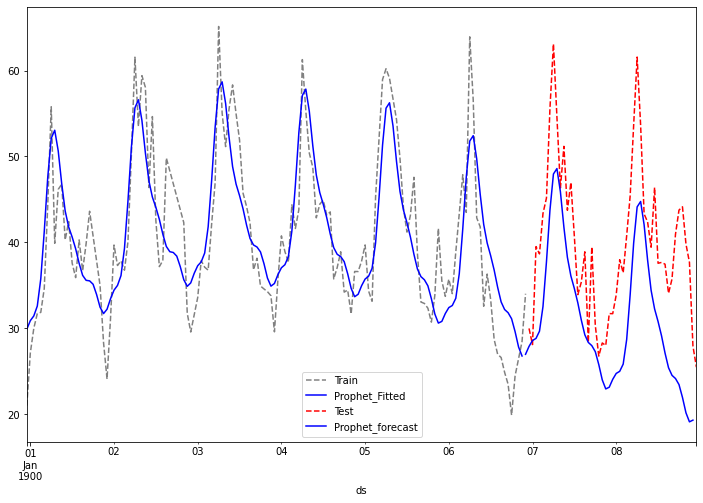

In [72]:
train_dx6_I["CPU %"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")

fb6_fc_df.set_index('ds')["yhat"].iloc[:-len(test_dx6_I)].plot(color="b", legend=True, label="Prophet_Fitted")

test_dx6_I["CPU %"].plot(style="--",color="r", legend=True, label="Test")

fb6_fc_df.set_index('ds')["yhat"].iloc[-len(test_dx6_I):].plot(color="b", legend=True, label="Prophet_forecast");

In [73]:
# Error metrics: root mean squared error
fb_rmse6 = np.round(rmse(test_dx6_I["CPU %"], fb6_fc["yhat"].values),2)
fb_rmse6

11.01

In [74]:
# Summary error metric Prophet
model_errors_fb = pd.DataFrame({
    "Data": ['data 1', 'data 2','data 3','data 4','data 5','data 6',],
    "RMSE": [fb_rmse, fb_rmse2, fb_rmse3, fb_rmse4, fb_rmse5, fb_rmse6]
})

model_errors_fb

,Data,RMSE
0,data 1,9.60
1,data 2,18.92
2,data 3,7.43
3,data 4,8.89
4,data 5,9.17
5,data 6,11.01


# LSTM

To improve the model's performance, tune the following hyperparameters:


*   Number of neurons/units
*   Number of epochs
*   Input size
*   Adding/changing layers
*   Modifying the dropout (regularization) value
*   Activation function
*   Optimizer


In [75]:
# Root mean squared error helper function
def frmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

### Dataset 1

In [76]:
# Learning from 24 days of data to predict one datapoint

seed_value=0
tf.random.set_seed(seed_value)

# train-test split
train_lstm, test_lstm = np.split(dx_re, [int(.75 *len(dx_re))])

timestep = 24

# train data
x_train=[]
y_train=[]

for i in range(timestep,train_lstm.shape[0]):
    x_train.append(train_lstm.iloc[i-timestep:i,0])
    y_train.append(train_lstm.iloc[i,0])

x_train , y_train = np.array(x_train),np.array(y_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1) # reshaping dimensions

# test data
x_test=[]
y_test=[]

for i in range(timestep,test_lstm.shape[0]):
    x_test.append(test_lstm.iloc[i-timestep:i,0])
    y_test.append(test_lstm.iloc[i,0])

x_test , y_test = np.array(x_test),np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1) # reshaping dimensions

In [77]:
# model
model1_lstm = Sequential()

# Add layers sequentially
model1_lstm.add(LSTM(24,activation="relu", input_shape=(24,1))) # input layer
model1_lstm.add(Dropout(0.2)) # regularization
model1_lstm.add(Dense(1)) # output layer

model1_lstm.summary()

model1_lstm.compile(optimizer='adam', loss='mse', metrics=[frmse])

model1_lstm.fit(x_train,y_train,epochs=100,batch_size=32)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24)                2496      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 8ms/step - loss: 1317.6340 - frmse: 35.1799
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 1129.1715 - frmse: 32.1276
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 636.4514 - frmse: 22.9464
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 431.1396 - frmse: 17

In [78]:
# Root Mean Squared Error
test1_loss, rmse1_lstm = model1_lstm.evaluate(x_test, y_test, batch_size=32)
print('LSTM rmse:', rmse1_lstm)

1/1 [==============================] - 0s 2ms/step - loss: 25.8413 - frmse: 4.3422
LSTM rmse: 4.342169284820557


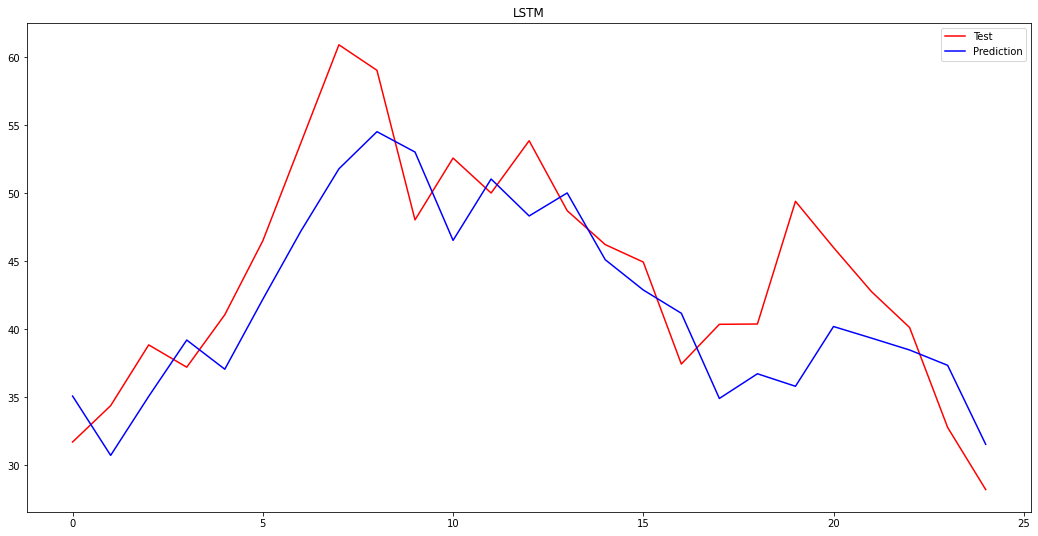

In [79]:
# prediction
y_pred1 = model1_lstm.predict(x_test)

plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'red', label = 'Test')
plt.plot(y_pred1[:,0], color = 'blue', label = 'Prediction')
plt.legend()
plt.title("LSTM")
plt.show()

### Dataset 2

In [80]:
# learning from 24 days of data to predict one datapoint

seed_value=0
tf.random.set_seed(seed_value)

# train-test split
train_lstm, test_lstm = np.split(dx2_re, [int(.75 *len(dx2_re))])

timestep = 24

# train data
x_train=[]
y_train=[]

for i in range(timestep,train_lstm.shape[0]):
    x_train.append(train_lstm.iloc[i-timestep:i,0])
    y_train.append(train_lstm.iloc[i,0])

x_train , y_train = np.array(x_train),np.array(y_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1) # reshaping dimensions

# test data
x_test=[]
y_test=[]

for i in range(timestep,test_lstm.shape[0]):
    x_test.append(test_lstm.iloc[i-timestep:i,0])
    y_test.append(test_lstm.iloc[i,0])

x_test , y_test = np.array(x_test),np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1) # reshaping dimensions

In [81]:
# model
model2_lstm = Sequential()

# Add layers sequentially
model2_lstm.add(LSTM(24,activation="relu", input_shape=(24,1))) # input layer
model2_lstm.add(Dropout(0.2)) # regularization
model2_lstm.add(Dense(1)) # output layer

model2_lstm.summary()

model2_lstm.compile(optimizer='adam', loss='mse', metrics=[frmse])

model2_lstm.fit(x_train,y_train,epochs=100,batch_size=32)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24)                2496      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 8ms/step - loss: 1420.1263 - frmse: 36.7431
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 1187.0751 - frmse: 33.1025
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 653.5366 - frmse: 23.4344
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 456.8083 - frmse: 

In [82]:
# Root Mean Squared Error
test2_loss, rmse2_lstm = model2_lstm.evaluate(x_test, y_test, batch_size=32)
print('LSTM rmse:', rmse2_lstm)

1/1 [==============================] - 0s 1ms/step - loss: 215.6930 - frmse: 9.5538
LSTM rmse: 9.553767204284668


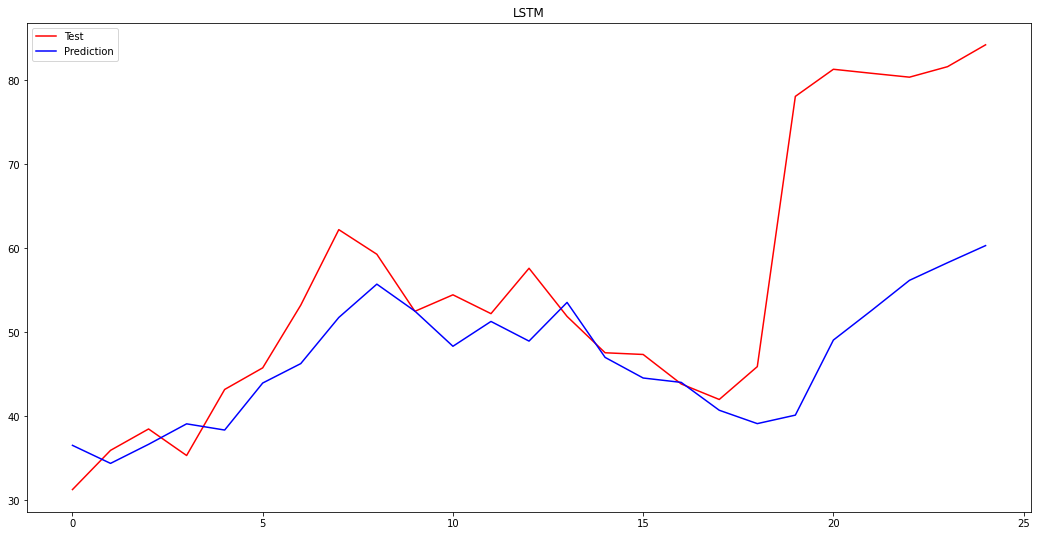

In [83]:
# prediction
y_pred2 = model2_lstm.predict(x_test)

plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'red', label = 'Test')
plt.plot(y_pred2[:,0], color = 'blue', label = 'Prediction')
plt.legend()
plt.title("LSTM")
plt.show()

### Dataset 3

In [84]:
# training data: learning from 24 days of data to predict

seed_value=0
tf.random.set_seed(seed_value)

# train-test split
train_lstm, test_lstm = np.split(dx3_re, [int(.75 *len(dx3_re))])

timestep = 24

# train data
x_train=[]
y_train=[]

for i in range(timestep,train_lstm.shape[0]):
    x_train.append(train_lstm.iloc[i-timestep:i,0])
    y_train.append(train_lstm.iloc[i,0])

x_train , y_train = np.array(x_train),np.array(y_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1) # reshaping dimensions

# test data
x_test=[]
y_test=[]

for i in range(timestep,test_lstm.shape[0]):
    x_test.append(test_lstm.iloc[i-timestep:i,0])
    y_test.append(test_lstm.iloc[i,0])

x_test , y_test = np.array(x_test),np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1) # reshaping dimensions

In [85]:
# model
model3_lstm = Sequential()

# Add layers sequentially
model3_lstm.add(LSTM(24,activation="relu", input_shape=(24,1))) # input layer
model3_lstm.add(Dropout(0.2)) # regularization
model3_lstm.add(Dense(1)) # output layer

model3_lstm.summary()

model3_lstm.compile(optimizer='adam', loss='mse', metrics=[frmse])

model3_lstm.fit(x_train,y_train,epochs=100,batch_size=32)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24)                2496      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 8ms/step - loss: 1191.5978 - frmse: 33.2716
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 1056.3882 - frmse: 31.0349
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 625.3743 - frmse: 22.6093
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 416.8419 - frmse: 

In [86]:
# Root Mean Squared Error
test3_loss, rmse3_lstm = model3_lstm.evaluate(x_test, y_test, batch_size=32)
print('LSTM rmse:', rmse3_lstm)

1/1 [==============================] - 0s 2ms/step - loss: 36.0063 - frmse: 4.6986
LSTM rmse: 4.698558807373047


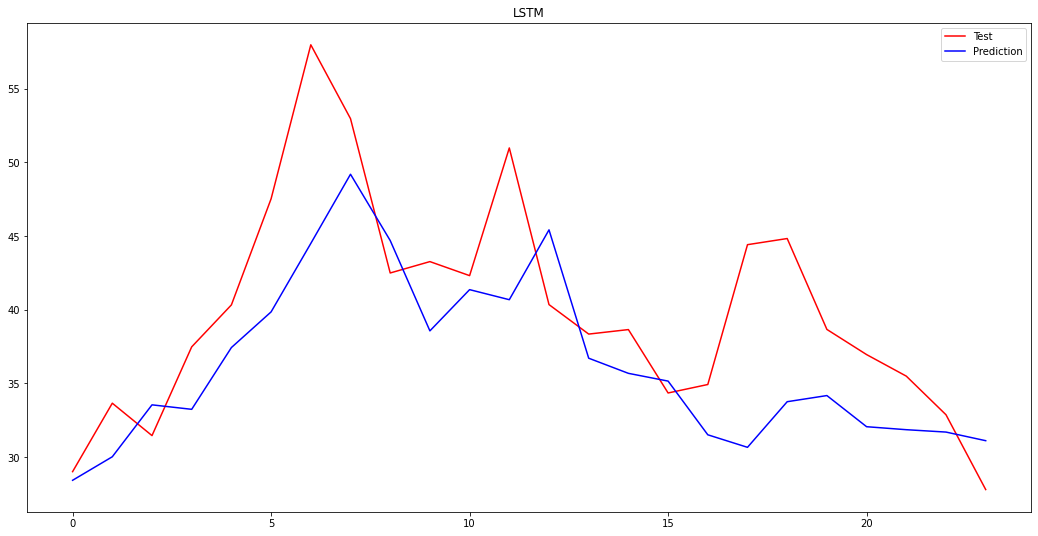

In [87]:
# prediction
y_pred3 = model3_lstm.predict(x_test)

plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'red', label = 'Test')
plt.plot(y_pred3[:,0], color = 'blue', label = 'Prediction')
plt.legend()
plt.title("LSTM")
plt.show()

### Dataset 4

In [88]:
# training data: learning from 24 days of data to predict

seed_value=0
tf.random.set_seed(seed_value)

# train-test split
train_lstm, test_lstm = np.split(dx4_re, [int(.75 *len(dx4_re))])

timestep = 24

# train data
x_train=[]
y_train=[]

for i in range(timestep,train_lstm.shape[0]):
    x_train.append(train_lstm.iloc[i-timestep:i,0])
    y_train.append(train_lstm.iloc[i,0])

x_train , y_train = np.array(x_train),np.array(y_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1) # reshaping dimensions

# test data
x_test=[]
y_test=[]

for i in range(timestep,test_lstm.shape[0]):
    x_test.append(test_lstm.iloc[i-timestep:i,0])
    y_test.append(test_lstm.iloc[i,0])

x_test , y_test = np.array(x_test),np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1) # reshaping dimensions

In [89]:
# model
model4_lstm = Sequential()

# Add layers sequentially
model4_lstm.add(LSTM(24,activation="relu", input_shape=(24,1))) # input layer
model4_lstm.add(Dropout(0.2)) # regularization
model4_lstm.add(Dense(1)) # output layer

model4_lstm.summary()

model4_lstm.compile(optimizer='adam', loss='mse', metrics=[frmse])

model4_lstm.fit(x_train,y_train,epochs=100,batch_size=32)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24)                2496      
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 8ms/step - loss: 770.2697 - frmse: 26.2004
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 725.4788 - frmse: 25.2062
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 559.4911 - frmse: 21.3955
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 346.8984 - frmse: 15

In [90]:
# Root Mean Squared Error
test4_loss, rmse4_lstm = model4_lstm.evaluate(x_test, y_test, batch_size=32)
print('LSTM rmse:', rmse4_lstm)

1/1 [==============================] - 0s 2ms/step - loss: 31.1463 - frmse: 4.4590
LSTM rmse: 4.459022521972656


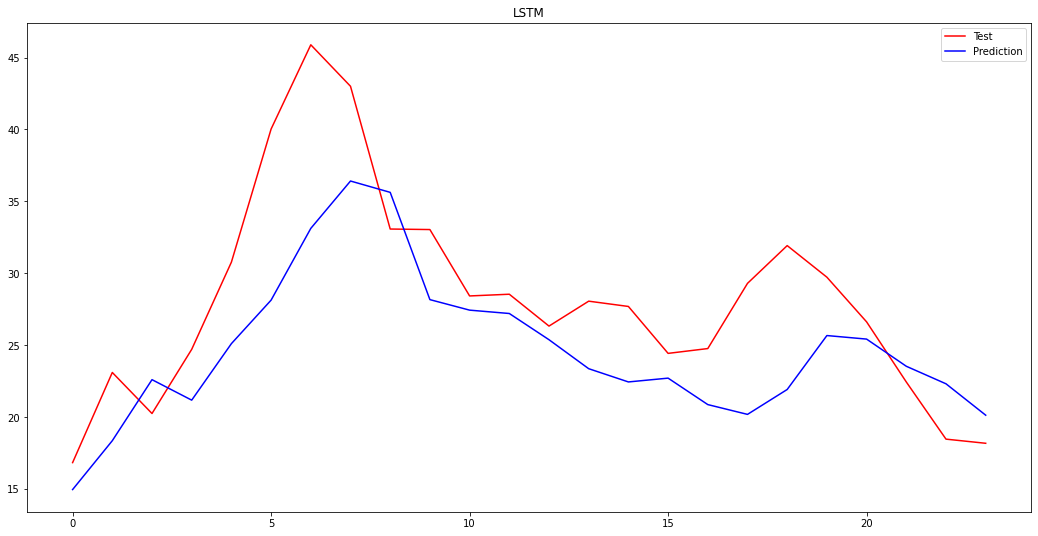

In [91]:
# prediction
y_pred4 = model4_lstm.predict(x_test)

plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'red', label = 'Test')
plt.plot(y_pred4[:,0], color = 'blue', label = 'Prediction')
plt.legend()
plt.title("LSTM")
plt.show()

### Dataset 5

In [92]:
# training data: learning from 24 days of data to predict
seed_value=0
tf.random.set_seed(seed_value)

# train-test split
train_lstm, test_lstm = np.split(dx5_re, [int(.75 *len(dx5_re))])

timestep = 24

# train data
x_train=[]
y_train=[]

for i in range(timestep,train_lstm.shape[0]):
    x_train.append(train_lstm.iloc[i-timestep:i,0])
    y_train.append(train_lstm.iloc[i,0])

x_train , y_train = np.array(x_train),np.array(y_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1) # reshaping dimensions

# test data
x_test=[]
y_test=[]

for i in range(timestep,test_lstm.shape[0]):
    x_test.append(test_lstm.iloc[i-timestep:i,0])
    y_test.append(test_lstm.iloc[i,0])

x_test , y_test = np.array(x_test),np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1) # reshaping dimensions

In [93]:
# model
model5_lstm = Sequential()

# Add layers sequentially
model5_lstm.add(LSTM(24,activation="relu", input_shape=(24,1))) # input layer
model5_lstm.add(Dropout(0.2)) # regularization
model5_lstm.add(Dense(1)) # output layer

model5_lstm.summary()

model5_lstm.compile(optimizer='adam', loss='mse', metrics=[frmse])

model5_lstm.fit(x_train,y_train,epochs=100,batch_size=32)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24)                2496      
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 7ms/step - loss: 772.4592 - frmse: 26.2377
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 718.7399 - frmse: 25.1448
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 562.8961 - frmse: 21.4704
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 335.6856 - frmse: 15

In [94]:
# Root Mean Squared Error
test5_loss, rmse5_lstm = model5_lstm.evaluate(x_test, y_test, batch_size=32)
print('LSTM rmse:', rmse5_lstm)

1/1 [==============================] - 0s 3ms/step - loss: 22.3039 - frmse: 3.6482
LSTM rmse: 3.6481900215148926


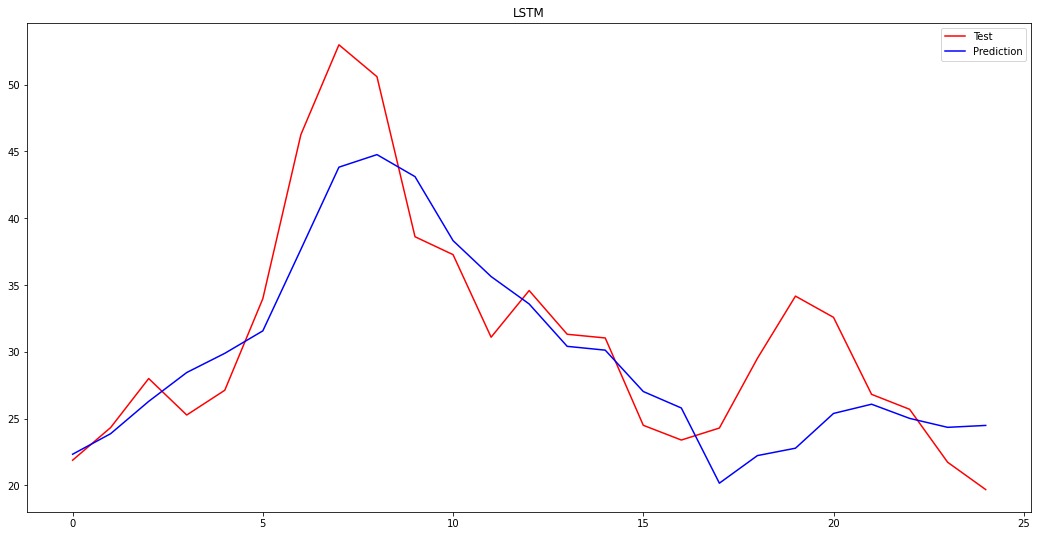

In [95]:
# prediction
y_pred5 = model5_lstm.predict(x_test)

plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'red', label = 'Test')
plt.plot(y_pred5[:,0], color = 'blue', label = 'Prediction')
plt.legend()
plt.title("LSTM")
plt.show()

### Dataset 6

In [96]:
# training data: learning from 24 days of data to predict
seed_value=0
tf.random.set_seed(seed_value)

# train-test split
train_lstm, test_lstm = np.split(dx6_re, [int(.75 *len(dx6_re))])

timestep = 24

# train data
x_train=[]
y_train=[]

for i in range(timestep,train_lstm.shape[0]):
    x_train.append(train_lstm.iloc[i-timestep:i,0])
    y_train.append(train_lstm.iloc[i,0])

x_train , y_train = np.array(x_train),np.array(y_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1) # reshaping dimensions

# test data
x_test=[]
y_test=[]

for i in range(timestep,test_lstm.shape[0]):
    x_test.append(test_lstm.iloc[i-timestep:i,0])
    y_test.append(test_lstm.iloc[i,0])

x_test , y_test = np.array(x_test),np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1) # reshaping dimensions

In [97]:
# model

model6_lstm = Sequential()

# Add layers sequentially
model6_lstm.add(LSTM(24,activation="relu", input_shape=(24,1))) # input layer
model6_lstm.add(Dropout(0.2)) # regularization
model6_lstm.add(Dense(1)) # output layer

model6_lstm.summary()

model6_lstm.compile(optimizer='adam', loss='mse', metrics=[frmse])

model6_lstm.fit(x_train,y_train,epochs=100,batch_size=32)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 24)                2496      
_________________________________________________________________
dropout_5 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 8ms/step - loss: 1241.4396 - frmse: 34.1079
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 1077.4514 - frmse: 31.4161
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 603.1133 - frmse: 22.3272
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 397.9797 - frmse: 

In [98]:
# Root Mean Squared Error
test6_loss, rmse6_lstm = model6_lstm.evaluate(x_test, y_test, batch_size=32)
print('LSTM rmse:', rmse6_lstm)

1/1 [==============================] - 0s 8ms/step - loss: 35.5074 - frmse: 4.6659
LSTM rmse: 4.665937423706055


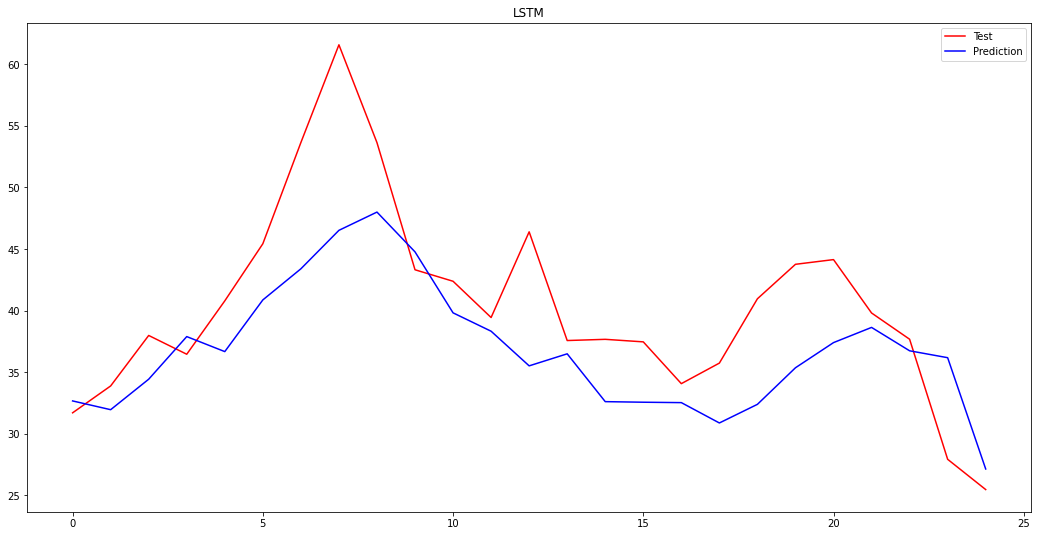

In [99]:
# prediction
y_pred6 = model6_lstm.predict(x_test)

plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'red', label = 'Test')
plt.plot(y_pred6[:,0], color = 'blue', label = 'Prediction')
plt.legend()
plt.title("LSTM")
plt.show()

In [100]:
# Summary of LSTM error metrics
model_errors_lstm = pd.DataFrame({
    "Data": ['data 1', 'data 2','data 3','data 4','data 5','data 6',],
    "RMSE": [rmse1_lstm, rmse2_lstm, rmse3_lstm, rmse4_lstm, rmse5_lstm, rmse6_lstm]
})

model_errors_lstm

,Data,RMSE
0,data 1,4.342169
1,data 2,9.553767
2,data 3,4.698559
3,data 4,4.459023
4,data 5,3.648190
5,data 6,4.665937


# Conclusion

In [101]:
# resemble the rmse data sets
rmse_df=pd.DataFrame(data=list(zip(model_errors_exp['Data'],
                      model_errors_exp['RMSE'],
                      model_errors_sarima['RMSE'],
                      model_errors_fb['RMSE'],
                      model_errors_lstm['RMSE'])),
                      columns=['Data', 'EXP_RMSE', 'SARIMA_RMSE','FB_RMSE','LSTM RMSE'])
rmse_df

,Data,EXP_RMSE,SARIMA_RMSE,FB_RMSE,LSTM RMSE
0,data 1,6.682616,9.25,9.60,4.342169
1,data 2,17.000511,17.96,18.92,9.553767
2,data 3,5.114815,5.25,7.43,4.698559
3,data 4,6.527768,8.52,8.89,4.459023
4,data 5,6.474686,6.62,9.17,3.648190
5,data 6,6.617912,9.85,11.01,4.665937


In order to defined the best model in statistical term, we use RMSE (Root mean square deviation) instead of MAPE due to the small value of data.

RMSE is the standard deviation of the residual (prediction errors) which the smaller the value leads the better prediction.

Therefore, by comparing each model’s RMSE value, the best model is LSTM.
